# Deep Learning

In [1]:
import torch
import copy
from torchvision import models
import time
import numpy as np
from pathlib import Path
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import accuracy_score

In [2]:
folder = Path('C:\\Users\\siddh\\Documents\\UTD\\BUAN 6v99 - DeepLearning\\HW4')

In [3]:
torch.manual_seed(99)
# define transformation
data_transformer = transforms.Compose([transforms.ToTensor()])
    
# loading data
train_ds = datasets.CIFAR10(folder, train=True, transform=data_transformer, download=True)
# print out data shape
print(train_ds.data.shape)

Files already downloaded and verified
(50000, 32, 32, 3)


In [4]:
import collections

# get labels
y_train=[y for _,y in train_ds]

# count labels
counter_train=collections.Counter(y_train)
print(counter_train)

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


In [5]:
# loading data
test0_ds = datasets.CIFAR10(folder, train=False, transform=data_transformer, download=True)
print(test0_ds.data.shape)

Files already downloaded and verified
(10000, 32, 32, 3)


## Next, split the indices of test0_ds into two groups:

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=list(range(len(test0_ds)))
y_test0=[y for _,y in test0_ds]
for test_index, val_index in sss.split(indices, y_test0):
    print("test:", test_index, "val:", val_index)
    print(len(val_index),len(test_index))

test: [5278 3265  795 ...  712  139 5732] val: [5712 7359  919 ... 3641  142 6090]
2000 8000


## Create Validation and test dataset

In [7]:
from torch.utils.data import Subset

val_ds=Subset(test0_ds,val_index)
test_ds=Subset(test0_ds,test_index)

## count the number of images per class in val_ds and test_ds

In [8]:
import collections
import numpy as np

# get labels
y_test=[y for _,y in test_ds]
y_val=[y for _,y in val_ds]

counter_test=collections.Counter(y_test)
counter_val=collections.Counter(y_val)

print(counter_test)
print(counter_val)

Counter({0: 800, 8: 800, 7: 800, 6: 800, 3: 800, 1: 800, 4: 800, 2: 800, 5: 800, 9: 800})
Counter({2: 200, 1: 200, 0: 200, 6: 200, 9: 200, 4: 200, 3: 200, 5: 200, 8: 200, 7: 200})


##  Show a few sample images from train_ds

image indices: [ 2732 43567 42613 45891]
torch.Size([3, 36, 138])


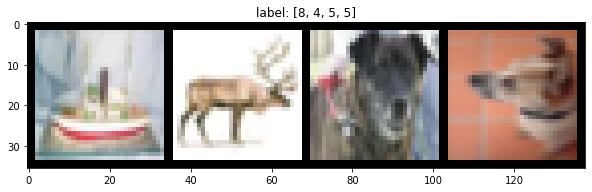

In [9]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

## Show a few sample images from val_ds

image indices: [ 684  559 1653 1216]
torch.Size([3, 36, 138])


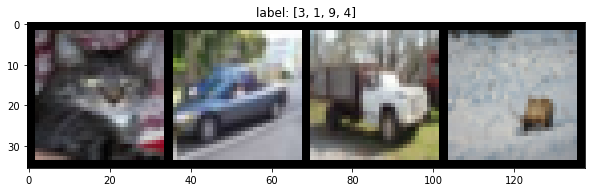

In [10]:
np.random.seed(0)

grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[val_ds[i][0] for i in rnd_inds]
y_grid=[val_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

## Calculate the mean and standard deviation of train_ds

In [11]:
# RGB mean and std 
meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds]

meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR,meanG,meanB)
print(stdR,stdG,stdB)

0.49139965 0.48215845 0.4465309
0.20220213 0.19931543 0.20086348


## Data Transformation

For test0_ds, we only added the normalization function since we do not require data augmentation for the validation and test datasets

In [12]:
train_transformer = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])])
                 

test0_transformer = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
    ]) 

# overwrite the transform functions
# Note that when we update the test0_ds.transform function, both val_ds, 
# and test_ds will be updated since they are subsets of test0_ds.
train_ds.transform=train_transformer
test0_ds.transform=test0_transformer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [ 2732 43567 42613 45891]
torch.Size([3, 36, 138])


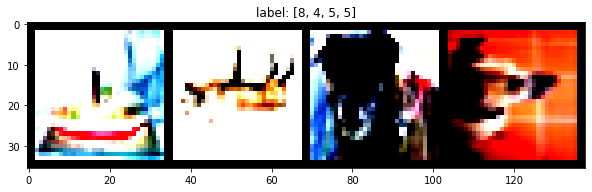

In [15]:
np.random.seed(0)
torch.manual_seed(0)

# make a grid
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [16]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)  

In [17]:
# extract a batch from training data
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [18]:
# extract a batch from validation data
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [19]:
# A helper function to count the number of correct predictions per data batch:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [20]:
# A helper function to compute the loss value per batch of data:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [21]:
# a helper function to compute the loss value and the performance metric for the entire dataset or an epoch.

# define device as a global variable
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    device = torch.device("cuda")
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [22]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step()

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [23]:
def deploy_model(model,dataset,device, num_classes=10,sanity_check=False):

    len_data=len(dataset)
    
    # initialize output tensor on CPU: due to GPU memory limits
    y_out=torch.zeros(len_data,num_classes)
    
    # initialize ground truth on CPU: due to GPU memory limits
    y_gt=np.zeros((len_data),dtype="uint8")
    
    # move model to device
    model=model.to(device)
    
    elapsed_times=[]
    with torch.no_grad():
        for i in range(len_data):
            x,y=dataset[i]
            y_gt[i]=y
            start=time.time()    
            yy=model(x.unsqueeze(0).to(device))
            y_out[i]=torch.softmax(yy,dim=1)
            elapsed=time.time()-start
            elapsed_times.append(elapsed)

            if sanity_check is True:
                break

    inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms " %(device,inference_time))
    return y_out.numpy(),y_gt

In [24]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Different pre-trained models

## 1. AlexNet

In [23]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)  

In [24]:
# extract a batch from training data
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [25]:
# extract a batch from validation data
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [26]:
# load model with pretrained weights
alexnet_pretrained = models.alexnet(pretrained=True)
alexnet_pretrained

# Freeze training for all layers
for param in alexnet_pretrained.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
class_names = train_ds.classes
num_features = alexnet_pretrained.classifier[6].in_features
features = list(alexnet_pretrained.classifier.children())[:-1] # Remove last layer

extra_layer = nn.Linear(in_features=num_features, out_features=10, bias=True)

features.extend([extra_layer]) # Add our layer with 4 outputs
alexnet_pretrained.classifier = nn.Sequential(*features) # Replace the model classifier
print(alexnet_pretrained)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
device = torch.device("cuda:0")
alexnet_pretrained.to(device) 

# Even though the original image sizes are 96*96, we need to resize them to 224*224, 
# the same size that the resnet18 model was trained at.
from torchsummary import summary
summary(alexnet_pretrained, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       23,296
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       307,392
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       663,936
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       884,992
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      37,752,832
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Linear: 2-18                    

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       23,296
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       307,392
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       663,936
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       884,992
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      37,752,832
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Linear: 2-18                    

In [37]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(alexnet_pretrained.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 3,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "alexnet_pretrained.pt",
}

# train and validate the model
alexnet_pretrained,loss_hist,metric_hist=train_val(alexnet_pretrained,params_train)

Epoch 0/2, current lr=0.0001
Copied best model weights!
train loss: 0.722222, dev loss: 0.484487, accuracy: 84.10
----------
Epoch 1/2, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.482098, dev loss: 0.477865, accuracy: 84.45
----------
Epoch 2/2, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.372818, dev loss: 0.415262, accuracy: 87.20
----------


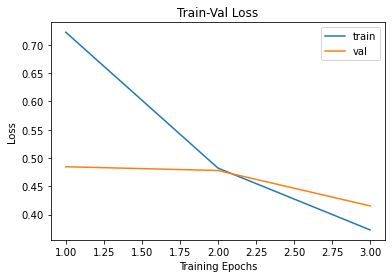

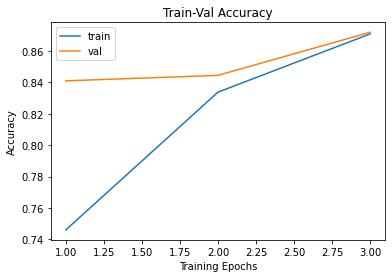

In [38]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [39]:
# load state_dict into model
path2weights=folder / "alexnet_pretrained.pt"
alexnet_pretrained.load_state_dict(torch.load(path2weights))

# set model in evaluation mode
alexnet_pretrained.eval();

# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    alexnet_pretrained=alexnet_pretrained.to(device)

# deploy model 
y_out,y_gt=deploy_model(alexnet_pretrained,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)



average inference time per image on cuda: 2.20 ms 
(2000, 10) (2000,)


In [40]:
# get predictions for train
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)

# get predictions for test
y_out,y_gt=deploy_model(alexnet_pretrained,test_ds,device=device)
y_pred = np.argmax(y_out,axis=1)
acc=accuracy_score(y_pred,y_gt)
print(acc)

(2000,) (2000,)
accuracy: 0.87
average inference time per image on cuda: 2.18 ms 
0.872


# 2. ResNet-18

In [26]:
# load model with pretrained weights
resnet18_pretrained = models.resnet18(pretrained=True)
num_ftrs = resnet18_pretrained.fc.in_features

# Freeze training for all layers
for param in resnet18_pretrained.parameters():
    param.require_grad = False

resnet18_pretrained.fc = nn.Linear(num_ftrs, 10)

print(resnet18_pretrained)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
device = torch.device("cuda:0")
resnet18_pretrained.to(device) 

# Even though the original image sizes are 32*32, we need to resize them to 224*224, 
# the same size that the resnet18 model was trained at.
from torchsummary import summary
summary(resnet18_pretrained, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

In [28]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(resnet18_pretrained.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 3,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "resnet18_pretrained.pt",
}

# train and validate the model
resnet18_pretrained,loss_hist,metric_hist=train_val(resnet18_pretrained,params_train)

Epoch 0/2, current lr=0.0001
Copied best model weights!
train loss: 0.496921, dev loss: 0.345762, accuracy: 87.55
----------
Epoch 1/2, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.275381, dev loss: 0.261756, accuracy: 90.85
----------
Epoch 2/2, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.186981, dev loss: 0.229439, accuracy: 91.75
----------


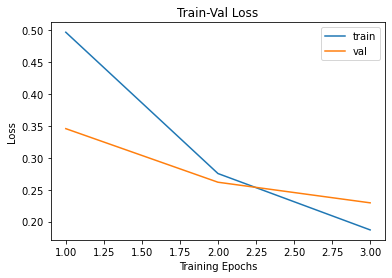

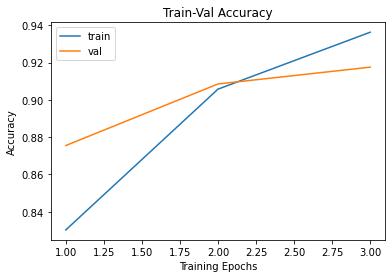

In [29]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [30]:
# load state_dict into model
path2weights=folder / "resnet18_pretrained.pt"
resnet18_pretrained.load_state_dict(torch.load(path2weights))

# set model in evaluation mode
resnet18_pretrained.eval();

# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    resnet18_pretrained=resnet18_pretrained.to(device)

# deploy model 
y_out,y_gt=deploy_model(resnet18_pretrained,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cuda: 3.25 ms 
(2000, 10) (2000,)


In [31]:
# get predictions for train
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)

# get predictions for test
y_out,y_gt=deploy_model(resnet18_pretrained,test_ds,device=device)
y_pred = np.argmax(y_out,axis=1)
acc=accuracy_score(y_pred,y_gt)
print(acc)

(2000,) (2000,)
accuracy: 0.92
average inference time per image on cuda: 3.33 ms 
0.933375


# 3. resnext50_32x4d

In [25]:
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
print(resnext50_32x4d)

# Freeze training for all layers
for param in resnext50_32x4d.parameters():
    param.require_grad = False


resnext50_32x4d.fc.out_features = 10

print(resnext50_32x4d)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [26]:
device = torch.device("cuda:0")
resnext50_32x4d.to(device) 

# Even though the original image sizes are 32*32, we need to resize them to 224*224, 
# the same size that the resnet18 model was trained at.
from torchsummary import summary
summary(resnext50_32x4d, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  8,192
|    |    └─BatchNorm2d: 3-2             256
|    |    └─Conv2d: 3-3                  4,608
|    |    └─BatchNorm2d: 3-4             256
|    |    └─Conv2d: 3-5                  32,768
|    |    └─BatchNorm2d: 3-6             512
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              16,896
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  32,768
|    |    └─BatchNorm2d: 3-10            256
|    |    └─Conv2d: 3-11                 4,608
|    |    └─BatchNorm2d: 3-12            256
|    |    └─Conv2d: 3-13                 32,768
|    |    └─BatchNorm2d: 3-14        

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  8,192
|    |    └─BatchNorm2d: 3-2             256
|    |    └─Conv2d: 3-3                  4,608
|    |    └─BatchNorm2d: 3-4             256
|    |    └─Conv2d: 3-5                  32,768
|    |    └─BatchNorm2d: 3-6             512
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              16,896
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  32,768
|    |    └─BatchNorm2d: 3-10            256
|    |    └─Conv2d: 3-11                 4,608
|    |    └─BatchNorm2d: 3-12            256
|    |    └─Conv2d: 3-13                 32,768
|    |    └─BatchNorm2d: 3-14        

In [28]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(resnext50_32x4d.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 3,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "resnext50_32x4d.pt",
}

# train and validate the model
resnext50_32x4d,loss_hist,metric_hist=train_val(resnext50_32x4d,params_train)

Epoch 0/2, current lr=0.0001
Copied best model weights!
train loss: 0.506593, dev loss: 0.276524, accuracy: 89.65
----------
Epoch 1/2, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.228311, dev loss: 0.213868, accuracy: 93.00
----------
Epoch 2/2, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.142673, dev loss: 0.189850, accuracy: 93.95
----------


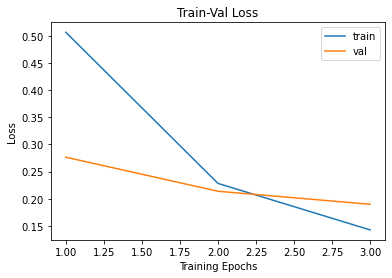

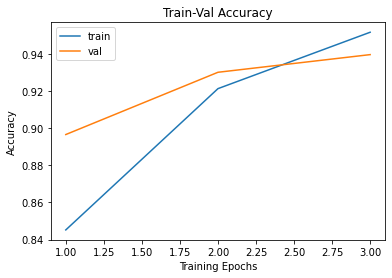

In [31]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# 4. GoogleNet

In [ ]:
train_transformer = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])])
                 

test0_transformer = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
    ]) 

# overwrite the transform functions
# Note that when we update the test0_ds.transform function, both val_ds, 
# and test_ds will be updated since they are subsets of test0_ds.
train_ds.transform=train_transformer
test0_ds.transform=test0_transformer

In [21]:
# load model with pretrained weights
googlenet_pretrained = models.googlenet(pretrained=True)
num_ftrs = googlenet_pretrained.fc.in_features

# Freeze training for all layers
for param in googlenet_pretrained.parameters():
    param.require_grad = False

googlenet_pretrained.fc = nn.Linear(num_ftrs, 10)

print(googlenet_pretrained)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [22]:
device = torch.device("cuda:0")
googlenet_pretrained.to(device) 

# Even though the original image sizes are 32*32, we need to resize them to 224*224, 
# the same size that the resnet18 model was trained at.
from torchsummary import summary
summary(googlenet_pretrained, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
├─MaxPool2d: 1-2                         --
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-3                       4,096
|    └─BatchNorm2d: 2-4                  128
├─BasicConv2d: 1-4                       --
|    └─Conv2d: 2-5                       110,592
|    └─BatchNorm2d: 2-6                  384
├─MaxPool2d: 1-5                         --
├─Inception: 1-6                         --
|    └─BasicConv2d: 2-7                  --
|    |    └─Conv2d: 3-1                  12,288
|    |    └─BatchNorm2d: 3-2             128
|    └─Sequential: 2-8                   --
|    |    └─BasicConv2d: 3-3             18,624
|    |    └─BasicConv2d: 3-4             110,848
|    └─Sequential: 2-9                   --
|    |    └─BasicConv2d: 3-5             3,104
|    |    └─BasicConv2d: 3-6            

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
├─MaxPool2d: 1-2                         --
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-3                       4,096
|    └─BatchNorm2d: 2-4                  128
├─BasicConv2d: 1-4                       --
|    └─Conv2d: 2-5                       110,592
|    └─BatchNorm2d: 2-6                  384
├─MaxPool2d: 1-5                         --
├─Inception: 1-6                         --
|    └─BasicConv2d: 2-7                  --
|    |    └─Conv2d: 3-1                  12,288
|    |    └─BatchNorm2d: 3-2             128
|    └─Sequential: 2-8                   --
|    |    └─BasicConv2d: 3-3             18,624
|    |    └─BasicConv2d: 3-4             110,848
|    └─Sequential: 2-9                   --
|    |    └─BasicConv2d: 3-5             3,104
|    |    └─BasicConv2d: 3-6            

In [23]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(googlenet_pretrained.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 3,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "googlenet_pretrained.pt",
}

# train and validate the model
googlenet_pretrained,loss_hist,metric_hist=train_val(googlenet_pretrained,params_train)

Epoch 0/2, current lr=0.0001
Copied best model weights!
train loss: 0.543356, dev loss: 0.278352, accuracy: 90.65
----------
Epoch 1/2, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.280201, dev loss: 0.229429, accuracy: 92.00
----------
Epoch 2/2, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.191735, dev loss: 0.212448, accuracy: 92.60
----------


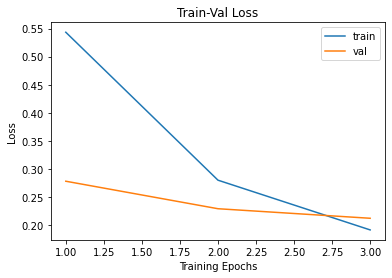

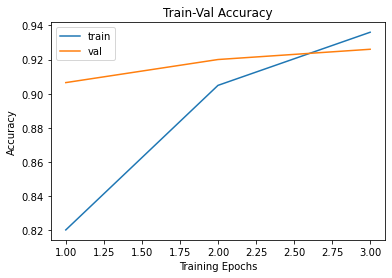

In [24]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [25]:
# load state_dict into model
path2weights=folder / "googlenet_pretrained.pt"
googlenet_pretrained.load_state_dict(torch.load(path2weights))

# set model in evaluation mode
googlenet_pretrained.eval();

# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    googlenet_pretrained=googlenet_pretrained.to(device)

# deploy model 
y_out,y_gt=deploy_model(googlenet_pretrained,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cuda: 9.00 ms 
(2000, 10) (2000,)


In [26]:
# get predictions for train
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)
acc=accuracy_score(y_pred,y_gt)
print("Train accuracy for googlenet_pretrained: %.2f" %acc)

# get predictions for test
y_out,y_gt=deploy_model(googlenet_pretrained,test_ds,device=device)
y_pred = np.argmax(y_out,axis=1)
acc=accuracy_score(y_pred,y_gt)
print("Test accuracy for googlenet_pretrained: %.2f" %acc)

(2000,) (2000,)
Train accuracy for googlenet_pretrained: 0.93
average inference time per image on cuda: 8.58 ms 
Test accuracy for googlenet_pretrained: 0.94
